<a href="https://colab.research.google.com/github/leonfrench/polyprotein_stats/blob/main/notebooks/classify_and_visualize_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
#workbook for building classifiers, looking at proportions and making the umap
#this is all rough and has been moved over to the streamlit app 

In [39]:
import pandas as pd
import functools
import numpy as np
import os, random
from datetime import datetime
from google.colab import drive
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from scipy import stats as scistats
from statsmodels.stats import multitest

import bokeh.io
import bokeh.plotting

In [40]:
embedding_file_path_processed = './gdrive/MyDrive/data/protein_embeddings_processed/'

In [41]:
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [42]:
def get_file_with_cache(filename):
	df = pd.read_csv(os.path.join(embedding_file_path_processed, filename))
	return df 

#this is split in two to allow easy deployment from github
def get_split_embeddings():
	dfA = get_file_with_cache("gene_symbol_summarized_prottrans_t5_xl_u50.1.csv.zip")
	dfB = get_file_with_cache("gene_symbol_summarized_prottrans_t5_xl_u50.2.csv.zip")
	full = pd.concat([dfA, dfB])
	return full 

#copies are needed because it gets modified - helps with cacheing
all_embeddings = get_split_embeddings().copy()
embedding_UMAP = get_file_with_cache("gene_symbol_summarized_UMAP.csv").copy()
proportions = get_file_with_cache("gene_symbol_summarized_proportions.csv").copy()

In [43]:
background_genes = ""

In [44]:
if (background_genes == ""):
  background_genes = all_embeddings['gene_symbol'].tolist()

In [45]:
target_genes = random.sample(all_embeddings['gene_symbol'].tolist(), 60)



In [46]:
background_matrices_genes = set(all_embeddings['gene_symbol']).intersection(proportions['gene_symbol'])

target_genes = set(target_genes)
target_genes_found =  target_genes.intersection(background_matrices_genes)

background_genes = set(background_genes)
background_genes_found =  background_genes.intersection(background_matrices_genes)


In [47]:
all_embeddings['classification_target'] = all_embeddings['gene_symbol'].isin(target_genes_found)
embedding_UMAP['classification_target'] = embedding_UMAP['gene_symbol'].isin(target_genes_found)
proportions['classification_target'] = proportions['gene_symbol'].isin(target_genes_found)
  
all_embeddings = all_embeddings[all_embeddings['gene_symbol'].isin(background_genes_found)]
embedding_UMAP = embedding_UMAP[embedding_UMAP['gene_symbol'].isin(background_genes_found)]
proportions = proportions[proportions['gene_symbol'].isin(background_genes_found)]


In [48]:
#ensure same order so the folds and targets line up
all_embeddings = all_embeddings.sort_values('gene_symbol')
proportions = proportions.sort_values('gene_symbol')

#should be equal to proportions target - needs checking
y = all_embeddings['classification_target']

X = all_embeddings.drop(['classification_target', 'gene_symbol'], axis = 1)
X_proportions = proportions.drop(['classification_target', 'gene_symbol'], axis = 1)


In [49]:
n_splits = 5
n_jobs = 1

In [50]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

In [51]:
%time
f1_scores = []
auc_scores = []
auc_scores_proportions = []
best_predicted_genes = []
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train = X.iloc[train_idx, :]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx, :]
    y_test = y.iloc[test_idx]

    X_proportions_train = X_proportions.iloc[train_idx, :]
    X_proportions_test = X_proportions.iloc[test_idx, :]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]



    model = LogisticRegression(n_jobs=n_jobs, max_iter=500)
    model.fit(X_train, y_train)
    
    # Extract predictions from fitted model
    preds = model.predict(X_test)
    # probs for classes ordered in same manner as model.classes_
    probas = pd.DataFrame(model.predict_proba(X_test), columns=model.classes_)

    # Get metrics for each model
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probas[True])
    f1_scores.append(f1)
    auc_scores.append(auc)
    #track the gene with the max prediction for the true class
    best_predicted_genes.append(all_embeddings.iloc[test_idx[probas.idxmax()[True]],:]['gene_symbol'])

    #run the model again with proportions instead of embeddings
    model.fit(X_proportions_train, y_train)
    probas = pd.DataFrame(model.predict_proba(X_proportions_test), columns=model.classes_)
    auc = roc_auc_score(y_test, probas[True])
    auc_scores_proportions.append(auc)
    





CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


In [17]:
best_predicted_genes = set(best_predicted_genes)
top_predicted_hits = best_predicted_genes.intersection(target_genes_found)
best_predicted_genes = best_predicted_genes.difference(target_genes_found)

In [18]:
scistats.ttest_1samp(auc_scores_proportions, 0.5).pvalue



0.6554002865782809

In [19]:
scistats.ttest_1samp(auc_scores, 0.5).pvalue

0.9134158488993919

In [20]:
auc_scores

[0.4848801742919391,
 0.5476470588235295,
 0.3117211328976035,
 0.6506714200831848,
 0.5372646443514644]

In [21]:
measures = {
            'number_of_input_genes': len(target_genes),
            'number_of_used_genes': len(target_genes_found),
            'number_of_input_background_genes': len(background_genes),
            'number_of_used_background_genes': len(background_genes_found),
            'f1': np.mean(f1_scores),
            'AUC': np.mean(auc_scores),
            'AUC standard dev': np.std(auc_scores),
            'AUC_p_value versus 0.5' : scistats.ttest_1samp(auc_scores, 0.5).pvalue, #two sided p-value testing the AUC values against 0.5 expecation
            'AUC proportions': np.mean(auc_scores_proportions),
            'AUC proportions p_value versus 0.5' : scistats.ttest_1samp(auc_scores_proportions, 0.5).pvalue, #two sided p-value testing the AUC values against 0.5 expecation
            'AUC proportions vrs embeddings pvalue' : scistats.ttest_rel(auc_scores, auc_scores_proportions).pvalue,
            'top_predicted_hits_in_folds' : best_predicted_genes,
            'top_genes_in_folds' : top_predicted_hits}


In [22]:
measures

{'AUC': 0.5064368860895442,
 'AUC proportions': 0.484413147182714,
 'AUC proportions p_value versus 0.5': 0.6554002865782809,
 'AUC proportions vrs embeddings pvalue': 0.6065171184535747,
 'AUC standard dev': 0.11120354866389177,
 'AUC_p_value versus 0.5': 0.9134158488993919,
 'f1': 0.0,
 'number_of_input_background_genes': 20282,
 'number_of_input_genes': 60,
 'number_of_used_background_genes': 19183,
 'number_of_used_genes': 59,
 'top_genes_in_folds': set(),
 'top_predicted_hits_in_folds': {'CCDC175',
  'CCDC178',
  'GOLGA6L22',
  'GOLGA6L6',
  'TMEM132A'}}

In [23]:
#generate predictions for all background genes, so they could be later tested for enrichment
model = LogisticRegression(n_jobs=n_jobs, max_iter=500)
model.fit(X, y)

LogisticRegression(max_iter=500, n_jobs=1)

In [32]:
# Extract predictions from fitted model and add gene symbol
preds = model.predict(X)
probas = pd.DataFrame(model.predict_proba(X), columns=model.classes_)
probas['classification_target'] = all_embeddings['classification_target'].tolist()
probas['gene_symbol'] = all_embeddings['gene_symbol'].tolist()


In [33]:
probas = probas.sort_values(True, ascending=False)

In [34]:
probas = probas.drop([False], axis=1)

In [35]:
probas = probas.rename(columns = {True : "pvalue_for_target_set"})

In [36]:
cols = probas.columns.tolist()
cols = cols[-1:] + cols[:-1]
probas = probas[cols]

In [37]:
probas

,gene_symbol,pvalue_for_target_set,classification_target
16656,TMEM132C,0.020615,True
16657,TMEM132D,0.020568,False
16654,TMEM132A,0.020437,False
16658,TMEM132E,0.018971,True
16655,TMEM132B,0.018379,False
...,...,...,...
8414,KRTAP5-9,0.000179,False
8362,KRTAP17-1,0.000177,False
8416,KRTAP6-2,0.000172,False
8379,KRTAP21-1,0.000157,False


In [ ]:
#download as streamlit table

In [ ]:
# Enable viewing Bokeh plots in the notebook
bokeh.io.output_notebook()

In [ ]:
x='UMAP 0'
y='UMAP 1'
p = bokeh.plotting.figure(
    width=640,
    height=400,
    x_axis_label=x,
    y_axis_label=y,
    tooltips=[
        ("Gene", "@{gene_symbol}"),('Target', '@{classification_target}')
    ],
)

In [ ]:
p.circle(
    source=embedding_UMAP[embedding_UMAP['classification_target'] == False], 
    x=x, 
    y=y,
    fill_color='lightgrey', line_color = 'lightgrey'
)


GlyphRenderer(id='1186', ...)

In [ ]:
p.circle(
    source=embedding_UMAP[embedding_UMAP['gene_symbol'].isin(best_predicted_genes)], 
    x=x, 
    y=y,
    fill_color='blue', line_color = 'blue'
)

GlyphRenderer(id='1194', ...)

In [ ]:
p.circle(
    source=embedding_UMAP[embedding_UMAP['classification_target'] == True], 
    x=x, 
    y=y,
    fill_color='red', line_color = 'red'
)

GlyphRenderer(id='1202', ...)

In [ ]:
bokeh.io.show(p)

In [ ]:
#make AUC plot

In [ ]:
proportions = pd.read_csv(os.path.join(embedding_file_path_processed, "gene_symbol_summarized_proportions.csv"))

proportions = proportions[proportions['gene_symbol'].isin(background_genes)]

residues = set(proportions.columns.values).difference(('gene_symbol','length'))

In [ ]:
proportions

,gene_symbol,M,K,V,T,A,E,I,S,W,N,F,L,G,D,Q,Y,H,P,R,C,length
0,A1BG,0.010598,0.027505,0.069531,0.064100,0.071552,0.078109,0.017288,0.075079,0.018927,0.020947,0.037225,0.120633,0.086935,0.038864,0.034824,0.018298,0.035834,0.090975,0.061202,0.021576,400.000000
1,A1CF,0.027583,0.065919,0.065969,0.059079,0.099312,0.066966,0.051410,0.040462,0.006537,0.042524,0.033074,0.078614,0.094005,0.042798,0.036495,0.048509,0.012446,0.061762,0.055396,0.011139,542.875000
2,A2M,0.024255,0.068036,0.102056,0.076468,0.050801,0.055588,0.031255,0.088731,0.001866,0.037295,0.036762,0.146992,0.066296,0.033100,0.030937,0.031280,0.027919,0.044583,0.029584,0.016197,451.250000
3,A2ML1,0.024095,0.053125,0.071410,0.063234,0.057455,0.044727,0.043194,0.104884,0.011146,0.039031,0.042689,0.109897,0.064593,0.038897,0.059611,0.036657,0.016105,0.057817,0.035954,0.024563,644.500000
4,A3GALT2,0.029412,0.026471,0.047059,0.035294,0.111765,0.055882,0.026471,0.041176,0.044118,0.014706,0.055882,0.120588,0.085294,0.038235,0.032353,0.023529,0.041176,0.064706,0.091176,0.014706,340.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20336,ZXDC,0.012037,0.041627,0.048945,0.055608,0.089749,0.048309,0.018578,0.119002,0.002902,0.024402,0.035763,0.098214,0.089239,0.044428,0.039708,0.009973,0.040871,0.092263,0.055113,0.032472,662.000000
20337,ZYG11A,0.035241,0.054338,0.058132,0.059731,0.075753,0.056657,0.048382,0.076192,0.013545,0.041232,0.055497,0.143512,0.024489,0.036875,0.062928,0.015144,0.027248,0.036717,0.048224,0.030164,531.000000
20338,ZYG11B,0.027575,0.051367,0.058722,0.062467,0.076504,0.060949,0.051617,0.066076,0.008027,0.043590,0.044474,0.148092,0.039807,0.049812,0.058050,0.010465,0.036062,0.032279,0.048929,0.025136,655.000000
20339,ZYX,0.012413,0.041358,0.049779,0.045027,0.090415,0.058709,0.019168,0.078399,0.004120,0.017996,0.035402,0.059316,0.071583,0.032089,0.081834,0.014908,0.023587,0.189411,0.042359,0.031316,316.428571


In [ ]:
proportions['classification_target'] = proportions['gene_symbol'].isin(target_genes)



In [ ]:
auc_for_length = roc_auc_score(proportions['classification_target'], proportions['length'])

In [ ]:
aa_AUC = []
#two for loops - it's symmetric, but super fast
neg = proportions[proportions['classification_target'] == 0]
pos = proportions[proportions['classification_target'] == 1]
for residueA in residues:
  for residueB in residues:
    if residueA <= residueB: #avoid computing full matrix - just the triangle
      auc = roc_auc_score(proportions['classification_target'], proportions[residueA] + proportions[residueB])
      pvalue = scistats.mannwhitneyu((pos[residueA] + pos[residueB]).tolist(), (neg[residueA] + neg[residueB]).tolist()).pvalue

      aa_AUC.append({'residue A': residueA, 'residue B' : residueB, 'auc' : auc, 'pvalue' : pvalue})
      #compute p-value
    #print(auc)
     
#fdr correct


In [ ]:
aa_AUC_df = pd.DataFrame(aa_AUC)
#as table

In [ ]:
aa_AUC_df['pvalue_bonf'] = multitest.multipletests(aa_AUC_df['pvalue'].tolist(), method="bonferroni")[1]

In [ ]:
aa_AUC_df.head()

,residue A,residue B,auc,pvalue,pvalue_bonf
0,M,M,0.542178,0.129235,1.0
1,M,W,0.532602,0.191211,1.0
2,M,P,0.545090,0.113522,1.0
3,M,S,0.509935,0.395059,1.0
4,M,Q,0.479555,0.291938,1.0


In [ ]:
aa_AUC_df_square = (aa_AUC_df.pivot(index=['residue B'],columns='residue A', values="auc")
         .sort_index(level=[1,0]))


In [ ]:
aa_AUC_df_square

residue A,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
residue B,,,,,,,,,,,,,,,,,,,,
A,0.492605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,0.507973,0.534884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D,0.490123,0.501553,0.468916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E,0.490467,0.518237,0.478890,0.486061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F,0.467195,0.512722,0.456153,0.470291,0.464869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G,0.492933,0.526115,0.490082,0.484597,0.476960,0.502547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H,0.486363,0.515037,0.463583,0.469561,0.458851,0.492030,0.485847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I,0.500537,0.548751,0.495561,0.480376,0.499799,0.505698,0.505278,0.518290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K,0.522483,0.550622,0.511172,0.510391,0.516824,0.527460,0.511206,0.509242,0.523735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


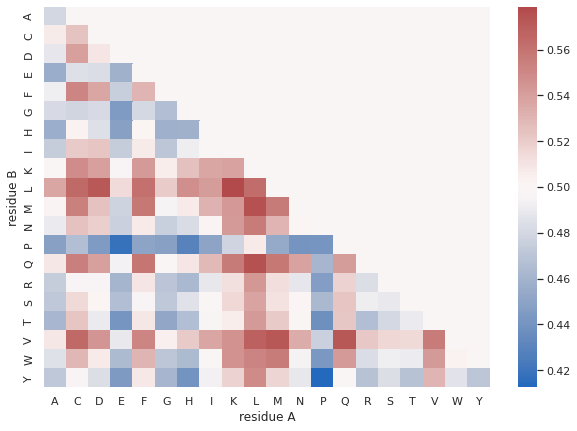

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
fig = plt.figure(figsize=(10, 7))
aa_AUC_df_square = aa_AUC_df_square.fillna(0.5)
ax = sns.heatmap(aa_AUC_df_square, center = 0.5, cmap = 'vlag')

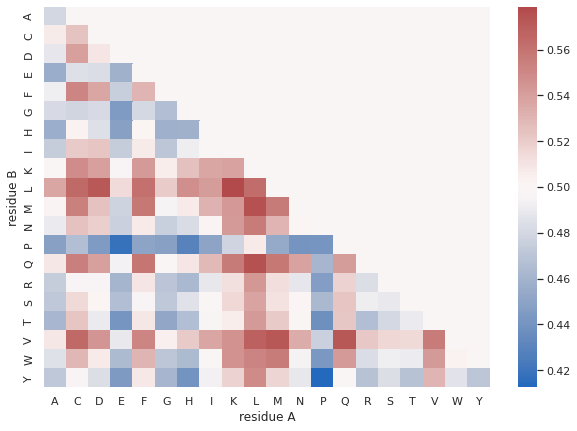

In [ ]:
fig